In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.special
from scipy.special import zeta, polygamma, factorial

Function to create an onion-type network based on the steps outlined in the following paper by Wu and Holme: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.84.026106

In [3]:
#GENERATE PROBABILITY DISTRIBUTION FOR DEGREES OF SCALE-FREE NETWORK
def degree_distribution(cutoff,gamma,xmin,N):
    probabilities=np.zeros(cutoff+1)
    normalization=scipy.special.zeta(gamma)

    for i in range(cutoff):
        probabilities[i]=(i+1)**(-gamma)
        probabilities[i]/=normalization

    psum=sum(probabilities)
    remainder=1-sum(probabilities)

    probabilities[cutoff]=remainder

    degrees=np.linspace(1,cutoff+1,cutoff+1)
    degree_distribution=np.random.choice(degrees,N,p=probabilities).astype(int)

    #print(degree_distribution)
    return degree_distribution

In [4]:
#CREATE NETWORK WITH N NODES AND NO EDGES
def onionnetwork(N):
    G=nx.Graph()
    for i in range(N):
        G.add_node(i)
    return G

In [5]:
#ASSIGN LAYER INDICES TO NODES
def node_layer_indices(G, degree_sequence):
    attr=dict()
    degrees=[]
    for x in degree_sequence:
        if x not in degrees:
            degrees.append(x)
    degrees.sort()
    
    for i in range(len(degrees)):
        mindegree=degrees[i]
        for node in G.nodes():
            if degree_sequence[node]==mindegree:
                nodeDict=dict()
                nodeDict["layer"]=i
                attr[node]=nodeDict
    nx.set_node_attributes(G,attr)
    return G            

In [6]:
#JOIN "STUBS" OF NODE LINKS to get onion-type network with scale-free degree distribution
def join_stubs(G,distribution,error):
    stubcount=np.copy(distribution)
    for i in G.nodes():
        for j in G.nodes():
            if i!=j:
                if stubcount[i]>0 and stubcount[j]>0:
                    #calculate probability of joining: 
                    diff=np.absolute(G.nodes[i]["layer"]-G.nodes[j]["layer"])
                    p=1/(1+diff)
                    x=np.random.uniform()                        
                    #if random number smaller than p, join nodes, decrease stubcounts
                    if x<=p:
                        G.add_edge(i,j)
                        stubcount[i]=stubcount[i]-1
                        stubcount[j]=stubcount[j]-1
    
    while sum(stubcount)>error:
        stubs=[]
        edgelist=[]
        for i in G.nodes():
            if stubcount[i]>0:
                stubs.append(i)
        for x in G.edges():
            edgelist.append(x)
        swap=np.random.choice(stubs,2)
        max=len(edgelist)
        index=np.random.randint(0,max)
        swapedge=edgelist[index]
        node1=swap[0]
        node2=swap[1]
        node3=swapedge[0]
        node4=swapedge[1]
        G.remove_edge(node3,node4)
        #print("removed:",(node1,node2))
        G.add_edge(node3,node1)
        G.add_edge(node4,node2)
        stubcount[node1]=stubcount[node1]-1
        stubcount[node2]=stubcount[node2]-1
        #print(sum(stubcount))
                    
    return G

The functions involved in the Prisoner's Dilemma simulation:

In [7]:
def payNode(network,node,temptation):
    P=1
    R=3
    S=0
    T=temptation
    payoffMatrix=[[R,S],[T,P]]
    self = int (network.nodes[node]["coop"]==0) #fordítva kell, mert a payoff matrix első sora a coop
    
    payoff=0
    
    for neighbor in network.neighbors(node):#összegzi a payoffokat, a kooperáció adja az indexet a mátrixhoz
        opponent= int (network.nodes[neighbor]["coop"]==0)
        payoff+=payoffMatrix[self][opponent]
        
    network.nodes[node]["payoff"]=payoff #új attribútomot kap a nódus
    
def updatePayoff(network,temptation):
    for node in network.nodes():
        payNode(network,node,temptation)

In [8]:
def updateNode (network,node): #sima besttakesover
    maxPayoff=network.nodes[node]["payoff"]
    maxPayNodes=[node]
    
    for neighbor in network.neighbors(node):
        if network.nodes[neighbor]["payoff"] == maxPayoff:
            maxPayNodes.append(neighbor) #itt a lényeg, nem csak azt menti el, ha nagyobb, több legnagyobb esetén random választ
        else:
            if network.nodes[neighbor]["payoff"]  > maxPayoff:
                maxPayoff=network.nodes[neighbor]["payoff"]
                maxPayNodes=[neighbor]
    network.nodes[node]["coop"]=network.nodes[np.random.choice(maxPayNodes)]["oldCoop"]
    
    
def updateStrategies(network,updatefraction):
    updatenumber=int(nx.number_of_nodes(network)*updatefraction)
    toupdate=np.random.choice(network.nodes(),updatenumber,replace=False)
    for node in network:
        network.nodes[node]["oldCoop"]=network.nodes[node]["coop"]
    
    for node in toupdate:
        updateNode(network,node)

In [9]:
def nextRound(G,temptation,updatefraction):
    #startTime= time.time()
    updatePayoff(G,temptation)
    updateStrategies(G,updatefraction)
    #draw(G)
    #print (time.time()-startTime)

In [10]:
def getGameCentrality(G):
    GC=0
    for node in G.nodes():
        GC+=G.nodes[node]["coop"]
        
    GC/=G.number_of_nodes()
    return GC

Simulation 1.
For different values of the temptation parameter, T, the Prisoner's Dilemma was played on the network for 15 steps, 100 times. The average proportion of cooperating nodes over the 100 simulations as a function of the temptation parameter T was plotted.

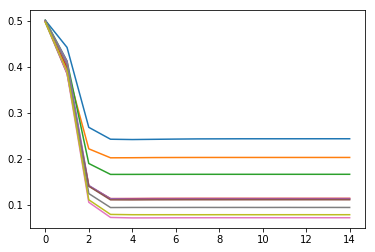

In [12]:
for T in [3,3.5,4,4.5,5,5.5,6,6.5,7]:
    
    simulations=100
    timesteps=15

    avg=np.zeros(timesteps)

    for k in range(simulations):
        #initialize onion-type network
        degrees=degree_distribution(200,2,2,500)
        G=onionnetwork(500)
        node_layer_indices(G, degrees)
        join_stubs(G, degrees, 10)
        density=(2*nx.number_of_edges(G))/(500*499)
        attr=dict()
        #play game
        for node in G.nodes():
            nodeDict=dict()
            nodeDict["coop"]=float('%.0f' %np.random.rand())
            attr[node]=nodeDict

        nx.set_node_attributes(G, attr)

        for t in range(timesteps):
            avg[t]+=getGameCentrality(G)
            nextRound(G,T,1)

    avg/=(simulations)   
    plt.plot(avg, label=(T))

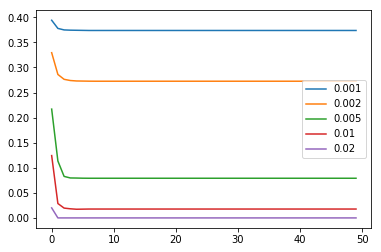

In [79]:
for n in [0.001,0.002,0.005,0.01,0.02]:
    simulations=20
    timesteps=50

    avg=np.zeros(timesteps)

    for k in range(simulations):
        G=nx.erdos_renyi_graph(500,n)
        for node in G.nodes():
            nodeDict=dict()
            nodeDict["coop"]=float('%.0f' %np.random.rand())
            attr[node]=nodeDict

        nx.set_node_attributes(G, attr)
        for t in range(timesteps):
            nextRound(G,5,1)
            avg[t]+=getGameCentrality(G)

    avg/=(simulations)      
    plt.plot(avg, label=n)
    plt.legend("network density")

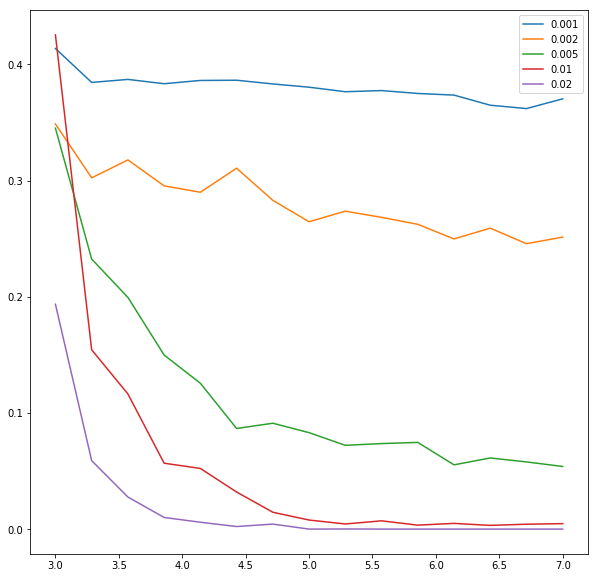

In [91]:
temptations=np.linspace(3,7,15)
plt.figure(figsize=(10,10))
for n in [0.001,0.002,0.005,0.01,0.02]:
    
    avg=np.zeros(len(temptations))
    for temp in range(len(temptations)):
        
        simulations=20
        timesteps=15

        for k in range(simulations):
            G=nx.erdos_renyi_graph(500,n)
            density=(2*nx.number_of_edges(G)/(500*499))

            attr=dict()
            for node in G.nodes():
                nodeDict=dict()
                nodeDict["coop"]=float('%.0f' %np.random.rand())
                attr[node]=nodeDict
            nx.set_node_attributes(G, attr)

            for t in range(timesteps):
                nextRound(G,temptations[temp],1)

            avg[temp]+=getGameCentrality(G)
    
    avg/=(simulations)
    plt.plot(temptations,avg,label=n)
    plt.legend()

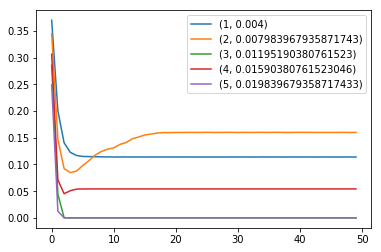

In [75]:
for n in [1,2,3,4,5]:
    simulations=20
    timesteps=50

    avg=np.zeros(timesteps)

    for k in range(simulations):
        G=nx.barabasi_albert_graph(500,n)
        for node in G.nodes():
            nodeDict=dict()
            nodeDict["coop"]=float('%.0f' %np.random.rand())
            attr[node]=nodeDict
        density=(2*nx.number_of_edges(G))/(500*499)
        nx.set_node_attributes(G, attr)

        for t in range(timesteps):
            nextRound(G,5,1)
            avg[t]+=getGameCentrality(G)

    avg/=(simulations)      
    plt.plot(avg, label=(n, density))
    plt.legend()

In [ ]:
-create optimized onion network
-rewire to randomize
-compare coop

In [30]:
def rewire_network(G):
    
    edgelist=list(G.edges())
    
    edges=np.random.choice(len(edgelist),2)
    
    edge1=edgelist[edges[0]]
    edge2=edgelist[edges[1]]
    
    i=edge1[0]
    j=edge1[1]
    k=edge2[0]
    l=edge2[1]
    
    G.remove_edge(i,j)
    G.remove_edge(k,l)
    G.add_edge(i,k)
    G.add_edge(j,l)
    
    return G